#Goal of Project: Explore 364 Men's Division 1 Basketball College Teams and focus on relationship with conferences and true shooting %, offensive rating, and defensive rating.

# As a fair warning, I want to say that the amount of errors running this specific API was infuriating, and if you see "try" and "except" functions I really don't know how they work, I had to find these similar issues on stackflow and they seemed to work, so that is for the lack of annotation I have in those regions.

In [ ]:
# import simple libraries to make work much easier.
from google.colab import drive
drive.mount('/content/drive')
import requests
import json
from requests.exceptions import HTTPError
import pandas as pd
from datetime import date, timedelta
import time

# API url
base_henry_url = "https://ncaa-api.henrygd.me"

# Running API ran errors until I included these headers
HEADERS = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/100.0.4896.127 Safari/537.36',
    'Accept': 'application/json',
}

# This is my json file, which would take close to 5 hours to run: all_basketball_games_raw_data.json
# This is my csv file: Division_1_Conferences.csv

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# First, I need to grab the game ID's for each matchup on each day.

# These are the start and end dates of the 2024-2025 season
start_date = date(2024, 11, 4)
end_date = date(2025, 4, 7)

# This API function will allow me to access the first branch of the API, which is the date of the game
def get_game_id_date(date_request):
  # turn the date into a string of YYYY/MM/DD
  date_string = date_request.strftime("%Y/%m/%d")
  # url holding the scoreboard branch
  scoreboard_url = f"{base_henry_url}/scoreboard/basketball-men/d1/{date_string}/all-conf"
  try:
        response = requests.get(scoreboard_url, headers=HEADERS)
        # This will raise an HTTPError for 4xx/5xx responses
        response.raise_for_status()

        data = response.json()

        # Extracts all valid game IDs

        # grabs the games branch and the list inside
        games_list = data.get("games", [])
        game_ids = []
        # iterate over the branch and grab the game url
        for item in games_list:
          game_data = item.get("game", {})
          game_url = game_data.get("url")
          if game_url:
            url_id = game_url.split("/")[-1]
            if url_id.isdigit():
              game_ids.append(url_id)

        print(f"Found {len(game_ids)} games for {date_string}")
        print(game_ids)
        return game_ids

    # Catch the specific HTTPError raised by response.raise_for_status()
  except HTTPError as e:
      if response.status_code == 404:
          print(f"Skipping {date_string}: No games found on this date (404 Not Found).")
          return [] # Return an empty list, allowing the main loop to continue
      else:
            # Handle other HTTP errors (e.g., 500 server error)
          print(f"HTTP Error for {date_string}: {e}")
          return []

  except requests.exceptions.RequestException as e:
        # Catch connection errors (e.g., network down)
      print(f"Connection Error for {date_string}: {e}")
      return []

# Then I need to grab the box score from each game played on the date given
def get_boxscore(game_ID):
  boxscore_url = f"{base_henry_url}/game/{game_ID}/boxscore"

  try:
        response = requests.get(boxscore_url, headers = HEADERS)
        response.raise_for_status() # Check for 4xx/5xx errors

        # Defensive JSON Parsing
        try:
            data = response.json()
        except json.JSONDecodeError:
            print(f"ERROR: JSON decode failed for Game ID {game_ID}. Skipping.")
            return []

  except HTTPError as e:
      print(f"HTTP Error fetching boxscore for {game_ID}: {e}")
      return []
  except requests.exceptions.RequestException as e:
      print(f"Connection Error fetching boxscore for {game_ID}: {e}")
      return []

Found 198 games for 2024/11/04
['6349703', '6351722', '6353422', '6354049', '6349955', '6350841', '6349613', '6380178', '6349393', '6349975', '6350232', '6350987', '6351150', '6350872', '6351360', '6352680', '6353773', '6353792', '6354820', '6349789', '6352325', '6352367', '6354347', '6354537', '6352540', '6349147', '6349159', '6349160', '6349234', '6349299', '6349317', '6349501', '6349593', '6349655', '6349712', '6349769', '6349954', '6350061', '6350085', '6350117', '6350217', '6350218', '6350489', '6350685', '6350715', '6350855', '6350883', '6350955', '6351073', '6351210', '6351453', '6351482', '6351701', '6352009', '6352033', '6352084', '6352559', '6352712', '6352834', '6352838', '6352892', '6352999', '6353020', '6353175', '6353194', '6353454', '6353519', '6353677', '6353700', '6353801', '6353842', '6353913', '6354008', '6354028', '6354186', '6354371', '6354454', '6354702', '6354758', '6354809', '6354840', '6354956', '6380053', '6380175', '6350122', '6350518', '6350887', '6351730', 

In [ ]:
# actual API information grabbing and placing into a dataframe

all_game_raw_jsons = [] # ⬅️ A list to hold the raw dictionaries for every game
current_date = start_date

# as long as current date is before the end of the season
while current_date <= end_date:
  #grab the game id from the url
    game_ids = get_game_id_date(current_date)
    # collect info every 4 seconds
    time.sleep(4)

    for game_id in game_ids:

        boxscore_url = f"{base_henry_url}/game/{game_id}/boxscore"

        try:
            response = requests.get(boxscore_url, headers=HEADERS)
            response.raise_for_status()
            raw_data = response.json()

            if raw_data:
                # Add a little metadata just so you know which game ID it belongs to later
                raw_data['metadata_game_id'] = game_id
                raw_data['metadata_date'] = current_date.isoformat()
                all_game_raw_jsons.append(raw_data)

            print(f"Collected raw JSON for Game ID {game_id}")

        except (HTTPError, requests.exceptions.RequestException, json.JSONDecodeError) as e:
            print(f"Error fetching raw data for Game ID {game_id}: {e}")
            continue

        time.sleep(1) # Collect every 1 second

    # increase the current day by 1 day
    current_date += timedelta(days=1)


# Save all collected raw data to a single large JSON file

output_filename = 'all_basketball_games_raw_data.json'

if all_game_raw_jsons:
    with open(output_filename, 'w') as f:
        # Use json.dump to write the entire list of dictionaries to a single file
        json.dump(all_game_raw_jsons, f, indent=4)

    print(f"\nSuccessfully saved {len(all_game_raw_jsons)} raw game records to {output_filename}")

    # Download it automatically in Colab
    from google.colab import files
    files.download(output_filename)
else:
    print("\nNo data was collected. The JSON file was not created.")

Streaming output truncated to the last 5000 lines.
Collected raw JSON for Game ID 6350233
Collected raw JSON for Game ID 6350690
Collected raw JSON for Game ID 6351459
Collected raw JSON for Game ID 6351810
Collected raw JSON for Game ID 6351893
Collected raw JSON for Game ID 6353489
Collected raw JSON for Game ID 6380060
Collected raw JSON for Game ID 6354851
Collected raw JSON for Game ID 6353917
Collected raw JSON for Game ID 6352117
Collected raw JSON for Game ID 6351912
Collected raw JSON for Game ID 6351538
Collected raw JSON for Game ID 6350583
Collected raw JSON for Game ID 6350468
Collected raw JSON for Game ID 6350376
Collected raw JSON for Game ID 6351633
Collected raw JSON for Game ID 6350674
Collected raw JSON for Game ID 6351933
Collected raw JSON for Game ID 6352190
Collected raw JSON for Game ID 6354704
Collected raw JSON for Game ID 6353293
Collected raw JSON for Game ID 6351038
Collected raw JSON for Game ID 6349861
Collected raw JSON for Game ID 6349672
Collected raw

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# turn the csv into a dataframe, also the encoding portion was giving me a hard time, so windows-1252 worked for some reason
conferences = pd.read_csv('Division_1_Conferences.csv', encoding='windows-1252')

In [ ]:
conferences.head()

,School,Nickname,Home arena,Conference,Tournament appearances,Final Four appearances,Championship wins
0,"University at Albany, SUNY (Albany or UAlbany)",Great Danes,SEFCU Arena,America East,"(5) 2006, 2007, 2013, 2014, 2015",0,0
1,Binghamton University,Bearcats,Binghamton University Events Center,America East,(1) 2009,0,0
2,Bryant University,Bulldogs,Chace Athletic Center,America East,"(2) 2022, 2025",0,0
3,University of Maine (UMaine),Black Bears,Memorial Gymnasium,America East,0,0,0
4,"University of Maryland, Baltimore County (UMBC)",Retrievers,Chesapeake Employers Insurance Arena,America East,"(2) 2008, 2018",0,0


Now that I have both dataframes in I get to clean them up.

First things first, I should look at my json file in order to determine where the information is. Since I decided to grab every single piece of information from the entire season, I now have to sort through it. Thankfully, I only need the team stats, not the players, so once I find the team stats portion I will just ignore anything that falls underneath.

JSON Breakdown:
About 500 lines in between games - 250 each team.
Nothing useful besides maybe contestId

Teams

↓

"name6char" (abbr) or "nameFull"

Back up to "teamBoxscore"

↓

goes through "playerStats"
also "teamStats" at end with everything I need besides possessions (which I will calculate with a formula used by NBA.com)

sidenote, teamId may be useful for the future for relational keys

also "metadata_date" as a main thing

So now, I am thinking about pulling all of this information and putting it into a dataframe, where the columns are team, 6 char abbreviation, full team name, every single team stat, team id, and then metadata_date

In [ ]:
from pandas import json_normalize
import numpy as np

In [ ]:
# contain the json data in a variable named basketball
basketball = 'all_basketball_games_raw_data.json'
# open the json in reaad mode, then normalize to the 'teamBoxscore' branch
with open(basketball, 'r') as opened:
  basketball = json.load(opened)
boxscore = pd.json_normalize(basketball, record_path = ['teamBoxscore'])

In [ ]:
boxscore.head()

,__typename,teamId,playerStats,teamStats.__typename,teamStats.fieldGoalsMade,teamStats.fieldGoalsAttempted,teamStats.freeThrowsMade,teamStats.freeThrowsAttempted,teamStats.threePointsMade,teamStats.threePointsAttempted,...,teamStats.totalRebounds,teamStats.assists,teamStats.turnovers,teamStats.personalFouls,teamStats.steals,teamStats.blockedShots,teamStats.points,teamStats.fieldGoalPercentage,teamStats.threePointPercentage,teamStats.freeThrowPercentage
0,BoxscoreDetails,2717,"[{'__typename': 'PlayerStatsBasketball', 'id':...",TeamStatsBasketball,37,81,14,23,12,31,...,64,20,5,12,7,0,100,4570.0%,3870.0%,6090.0%
1,BoxscoreDetails,1389034,[],TeamStatsBasketball,18,58,4,11,4,19,...,27,7,16,16,3,3,44,3100.0%,2110.0%,3640.0%
2,BoxscoreDetails,277,"[{'__typename': 'PlayerStatsBasketball', 'id':...",TeamStatsBasketball,25,62,25,33,5,21,...,27,12,9,21,11,1,80,4030.0%,2380.0%,7580.0%
3,BoxscoreDetails,1586,"[{'__typename': 'PlayerStatsBasketball', 'id':...",TeamStatsBasketball,31,55,19,30,9,20,...,38,17,17,23,3,4,90,5640.0%,4500.0%,6330.0%
4,BoxscoreDetails,446,"[{'__typename': 'PlayerStatsBasketball', 'id':...",TeamStatsBasketball,37,70,14,24,9,24,...,50,16,7,23,10,7,97,5290.0%,3750.0%,5830.0%


In [ ]:
# now normalize the .json in the teams branch to grab all the teams
teams = pd.json_normalize(basketball, record_path = ["teams"])
teams.head()

,__typename,isHome,teamId,seoname,name6Char,nameFull,nameShort,teamName,color
0,ContestTeam,True,2717,iu-indy,IUINDY,Indiana University Indianapolis,IU Indy,Jaguars,#A90533
1,ContestTeam,False,1389034,iupu-columbus,,IU Columbus,IU Columbus,,#CCCCCC
2,ContestTeam,True,277,southern-ill,SIU,Southern Illinois University at Carbondale,Southern Ill.,Salukis,#6F263D
3,ContestTeam,False,1586,col-of-charleston,C OF C,College of Charleston (South Carolina),Col. of Charleston,Cougars,#76232F
4,ContestTeam,True,446,middle-tenn,MIDTEN,Middle Tennessee State University,Middle Tenn.,Blue Raiders,#006FAB


Now I will clean each individual dataset in order to make sure there are no errors in the join process, starting with the conferences dataset.


In [ ]:
conferences.head()

,School,Nickname,Home arena,Conference,Tournament appearances,Final Four appearances,Championship wins
0,"University at Albany, SUNY (Albany or UAlbany)",Great Danes,SEFCU Arena,America East,"(5) 2006, 2007, 2013, 2014, 2015",0,0
1,Binghamton University,Bearcats,Binghamton University Events Center,America East,(1) 2009,0,0
2,Bryant University,Bulldogs,Chace Athletic Center,America East,"(2) 2022, 2025",0,0
3,University of Maine (UMaine),Black Bears,Memorial Gymnasium,America East,0,0,0
4,"University of Maryland, Baltimore County (UMBC)",Retrievers,Chesapeake Employers Insurance Arena,America East,"(2) 2008, 2018",0,0


This looks great so I am not going to touch it just yet. Now I will create a list of the schools in conferences in order to compare this to all the teams in the API file.

But there is one issue: there is no connecting point between these two datasets besides the name. So I will have to grab the unique names for each one, create a dataset with just those names then do:

df_A_transformed = pd.merge(
    df_dataset_A,
    mapping_df,
    left_on='Team_Name_Column_A',  # Name of the column in the large file
    right_on='Source_Name_Variation', # Name of the column in the map file
    how='left' # Keeps all original rows, adds the standardized name

For now, I can clean up the smaller datasets and place them into one large dataset.

In [ ]:
boxscore.columns

Index(['__typename', 'teamId', 'playerStats', 'teamStats.__typename',
       'teamStats.fieldGoalsMade', 'teamStats.fieldGoalsAttempted',
       'teamStats.freeThrowsMade', 'teamStats.freeThrowsAttempted',
       'teamStats.threePointsMade', 'teamStats.threePointsAttempted',
       'teamStats.offensiveRebounds', 'teamStats.totalRebounds',
       'teamStats.assists', 'teamStats.turnovers', 'teamStats.personalFouls',
       'teamStats.steals', 'teamStats.blockedShots', 'teamStats.points',
       'teamStats.fieldGoalPercentage', 'teamStats.threePointPercentage',
       'teamStats.freeThrowPercentage'],
      dtype='object')

In [ ]:
# Simply rename the columns in boxscore
boxscore = boxscore.rename(columns = {'teamStats.fieldGoalsMade': "FGM", 'teamStats.fieldGoalsAttempted': 'FGA', 'teamStats.freeThrowsMade': 'FTM', 'teamStats.freeThrowsAttempted': 'FTA',
'teamStats.threePointsMade': '3PM', 'teamStats.threePointsAttempted': '3PA', 'teamStats.offensiveRebounds': 'OREB', 'teamStats.totalRebounds': 'REB', 'teamStats.assists': 'ASST',
'teamStats.turnovers': 'TO', 'teamStats.personalFouls': 'PF', 'teamStats.steals': 'STL', 'teamStats.blockedShots': 'BLK', 'teamStats.points': 'PTS', 'teamStats.fieldGoalPercentage': 'FG%',
'teamStats.threePointPercentage': '3P%', 'teamStats.freeThrowPercentage': 'FT%'})

In [ ]:
# Now drop some of the remaining .json file columns that are useless to the project.
boxscore = boxscore.drop(columns = ['__typename', 'playerStats', 'teamStats.__typename'])

In [ ]:
# fill up all NA values with 0
boxscore = boxscore.fillna(0)

In [ ]:
# replace dashes in the free throw columns marking no free throws taken with 0's
boxscore['FT%'] = boxscore['FT%'].str.replace('-', '0')

In [ ]:
# Remove the % sign on the percentages and make them floats, then divide by 100 because they are too large
boxscore['FG%'] = boxscore['FG%'].str.rstrip('%').astype('float') / 100
boxscore['3P%'] = boxscore['3P%'].str.rstrip('%').astype('float') / 100
boxscore['FT%'] = boxscore['FT%'].str.rstrip('%').astype('float') / 100

In [ ]:
boxscore.head()

,teamId,FGM,FGA,FTM,FTA,3PM,3PA,OREB,REB,ASST,TO,PF,STL,BLK,PTS,FG%,3P%,FT%
0,2717,37,81,14,23,12,31,25,64,20,5,12,7,0,100,45.7,38.7,60.9
1,1389034,18,58,4,11,4,19,5,27,7,16,16,3,3,44,31.0,21.1,36.4
2,277,25,62,25,33,5,21,9,27,12,9,21,11,1,80,40.3,23.8,75.8
3,1586,31,55,19,30,9,20,8,38,17,17,23,3,4,90,56.4,45.0,63.3
4,446,37,70,14,24,9,24,14,50,16,7,23,10,7,97,52.9,37.5,58.3


Now, onto the teams dataframe to check one last time.

In [ ]:
# drop the useless .json columns from the API
teams = teams.drop(columns = ['__typename', 'seoname'])

In [ ]:
teams.head()

,isHome,teamId,name6Char,nameFull,nameShort,teamName,color
0,True,2717,IUINDY,Indiana University Indianapolis,IU Indy,Jaguars,#A90533
1,False,1389034,,IU Columbus,IU Columbus,,#CCCCCC
2,True,277,SIU,Southern Illinois University at Carbondale,Southern Ill.,Salukis,#6F263D
3,False,1586,C OF C,College of Charleston (South Carolina),Col. of Charleston,Cougars,#76232F
4,True,446,MIDTEN,Middle Tennessee State University,Middle Tenn.,Blue Raiders,#006FAB


In [ ]:
# make all values in boxscore into a float type
boxscore = boxscore.astype(float)

In [ ]:
boxscore.describe()

,teamId,FGM,FGA,FTM,FTA,3PM,3PA,OREB,REB,ASST,TO,PF,STL,BLK,PTS,FG%,3P%,FT%
count,1.248000e+04,12480.000000,12480.000000,12480.000000,12480.000000,12480.000000,12480.000000,12480.000000,12480.00000,12480.000000,12480.000000,12480.000000,12480.000000,12480.000000,12480.000000,12480.000000,12480.000000,12480.000000
mean,1.159228e+04,25.903766,58.512420,13.632853,18.972516,7.728926,22.887821,10.453926,34.99359,13.520994,12.024038,16.791907,6.831811,3.319712,73.171234,42.345067,32.086652,68.247173
std,1.059042e+05,5.365967,7.296465,5.939634,7.549498,3.251313,6.333095,4.122216,7.15513,4.812841,4.082831,4.270227,3.114272,2.159264,13.504615,11.875186,12.504979,19.341248
min,3.300000e+01,7.000000,36.000000,0.000000,0.000000,0.000000,5.000000,0.000000,13.00000,1.000000,0.000000,3.000000,0.000000,0.000000,19.000000,0.236000,0.000000,0.000000
25%,7.530000e+02,22.000000,54.000000,9.000000,13.000000,5.000000,18.000000,8.000000,30.00000,10.000000,9.000000,14.000000,5.000000,2.000000,64.000000,38.300000,25.000000,62.500000
50%,1.461000e+03,26.000000,58.000000,13.000000,18.000000,7.000000,22.000000,10.000000,35.00000,13.000000,12.000000,17.000000,7.000000,3.000000,73.000000,43.900000,33.300000,71.400000
75%,2.125000e+03,29.000000,63.000000,17.000000,24.000000,10.000000,27.000000,13.000000,39.00000,16.000000,14.000000,20.000000,9.000000,5.000000,81.000000,49.100000,40.000000,80.000000
max,1.389052e+06,54.000000,96.000000,48.000000,65.000000,25.000000,58.000000,32.000000,84.00000,41.000000,34.000000,40.000000,30.000000,15.000000,143.000000,71.600000,77.800000,100.000000


In [ ]:
boxscore.head()

,teamId,FGM,FGA,FTM,FTA,3PM,3PA,OR,TR,ASST,TO,PF,STL,BLK,PTS,FG%,3P%,FT%
0,2717.0,37.0,81.0,14.0,23.0,12.0,31.0,25.0,64.0,20.0,5.0,12.0,7.0,0.0,100.0,45.7,38.7,60.9
1,1389034.0,18.0,58.0,4.0,11.0,4.0,19.0,5.0,27.0,7.0,16.0,16.0,3.0,3.0,44.0,31.0,21.1,36.4
2,277.0,25.0,62.0,25.0,33.0,5.0,21.0,9.0,27.0,12.0,9.0,21.0,11.0,1.0,80.0,40.3,23.8,75.8
3,1586.0,31.0,55.0,19.0,30.0,9.0,20.0,8.0,38.0,17.0,17.0,23.0,3.0,4.0,90.0,56.4,45.0,63.3
4,446.0,37.0,70.0,14.0,24.0,9.0,24.0,14.0,50.0,16.0,7.0,23.0,10.0,7.0,97.0,52.9,37.5,58.3


Now that my datasets are clean, time to concatenate them!

In [ ]:
# creates a dataframe from our two API branch dataframes and just combines their columns horizontally
metrics = pd.concat([teams, boxscore], axis = 1)

In [ ]:
metrics.head()

,isHome,teamId,name6Char,nameFull,nameShort,teamName,color,teamId,FGM,FGA,...,REB,ASST,TO,PF,STL,BLK,PTS,FG%,3P%,FT%
0,True,2717,IUINDY,Indiana University Indianapolis,IU Indy,Jaguars,#A90533,2717.0,37.0,81.0,...,64.0,20.0,5.0,12.0,7.0,0.0,100.0,45.7,38.7,60.9
1,False,1389034,,IU Columbus,IU Columbus,,#CCCCCC,1389034.0,18.0,58.0,...,27.0,7.0,16.0,16.0,3.0,3.0,44.0,31.0,21.1,36.4
2,True,277,SIU,Southern Illinois University at Carbondale,Southern Ill.,Salukis,#6F263D,277.0,25.0,62.0,...,27.0,12.0,9.0,21.0,11.0,1.0,80.0,40.3,23.8,75.8
3,False,1586,C OF C,College of Charleston (South Carolina),Col. of Charleston,Cougars,#76232F,1586.0,31.0,55.0,...,38.0,17.0,17.0,23.0,3.0,4.0,90.0,56.4,45.0,63.3
4,True,446,MIDTEN,Middle Tennessee State University,Middle Tenn.,Blue Raiders,#006FAB,446.0,37.0,70.0,...,50.0,16.0,7.0,23.0,10.0,7.0,97.0,52.9,37.5,58.3


Now, I must create a column for the possessions, defensive rebounds, then offensive and defensive ratings according to the formula: (FGA - OREB) + TO + (0.44 * FTA) = POSS, ORAT = PTS/POSS * 100, DRAT = (PTS allowed / Possessions allowed) * 100, which I will have to grab by taking the above and below stats for certain rows.

In [ ]:
metrics['POSS'] = metrics['FGA'] - metrics['OREB'] + metrics['TO'] + (0.44 * metrics['FTA'])

In [ ]:
metrics['ORAT'] = (metrics['PTS'] / metrics['POSS']) * 100

In [ ]:
# using shift, which moves a row up or down, and by identifying if a game is home or away, we can make the offensive rating of a home team into the defensive rating
# of the away team, and vice versa
below_rating = metrics['ORAT'].shift(-1)
above_rating = metrics['ORAT'].shift(1)
metrics['DRAT'] = np.where(metrics['isHome'] == True, below_rating, above_rating)

In [ ]:
metrics['TS%'] = metrics['PTS']/(2 * (metrics['FGA'] + (.44 * metrics['FTA'])))

In [ ]:
metrics.head()

,isHome,teamId,name6Char,nameFull,nameShort,teamName,color,teamId,FGM,FGA,...,STL,BLK,PTS,FG%,3P%,FT%,POSS,ORAT,DRAT,TS%
0,True,2717,IUINDY,Indiana University Indianapolis,IU Indy,Jaguars,#A90533,2717.0,37.0,81.0,...,7.0,0.0,100.0,45.7,38.7,60.9,71.12,140.607424,59.588299,0.548727
1,False,1389034,,IU Columbus,IU Columbus,,#CCCCCC,1389034.0,18.0,58.0,...,3.0,3.0,44.0,31.0,21.1,36.4,73.84,59.588299,140.607424,0.350095
2,True,277,SIU,Southern Illinois University at Carbondale,Southern Ill.,Salukis,#6F263D,277.0,25.0,62.0,...,11.0,1.0,80.0,40.3,23.8,75.8,76.52,104.547831,116.580311,0.522739
3,False,1586,C OF C,College of Charleston (South Carolina),Col. of Charleston,Cougars,#76232F,1586.0,31.0,55.0,...,3.0,4.0,90.0,56.4,45.0,63.3,77.20,116.580311,104.547831,0.659824
4,True,446,MIDTEN,Middle Tennessee State University,Middle Tenn.,Blue Raiders,#006FAB,446.0,37.0,70.0,...,10.0,7.0,97.0,52.9,37.5,58.3,73.56,131.865144,68.807339,0.602036


Since that is officially complete, we can now work on comparing the names of the universities in both large datasets. This is going to take a long time to manually enter everything.

In [ ]:
# create lists of the names of the schools
conferences_names = conferences['School'].tolist()
stats_names = metrics['nameFull'].unique().tolist()

Now, time to compare them. I had to do a lot of research for this and found something called set and union, which compares the two lists and produces the unqiue names in both lists. This also allows me to copy and paste if the list is really large so that mapping is much easier. I also need to remove any D2 teams that played games against D1 teams, which will happen after the name mapping is eventually complete. Utilize dict(zip(list1, list2)) to make this quicker!

In [ ]:
for name in conferences_names:
  print(name)

University at Albany, SUNY (Albany or UAlbany)
Binghamton University
Bryant University
University of Maine (UMaine)
University of Maryland, Baltimore County (UMBC)
University of Massachusetts Lowell (UMass Lowell)
University of New Hampshire
New Jersey Institute of Technology (NJIT)
University of Vermont
University of North Carolina at Charlotte (Charlotte)
East Carolina University (ECU)
Florida Atlantic University (FAU)
University of Memphis (U of M)
University of North Texas (UNT)
Rice University
University of South Florida (USF)
Temple University
University of Alabama at Birmingham (UAB)
University of Texas at San Antonio (UTSA)
Tulane University
University of Tulsa
Wichita State University
Boston College (BC)
University of California, Berkeley (California, Cal)
Clemson University
Duke University
Florida State University (FSU)
Georgia Institute of Technology (Georgia Tech)
University of Louisville
University of Miami (often Miami (FL) or UM)
University of North Carolina at Chapel Hi

In [ ]:
standard_names = ['Albany', 'Binghamton', 'Bryant', 'UMaine', 'UMBC',
                  'UMass Lowell', 'New Hampshire', 'NJIT', 'Vermont', 'Charlotte', 'ECU', 'FAU', 'Memphis', 'North Texas', 'Rice', 'USF',
                  'Temple', 'UAB', 'UTSA', 'Tulane', 'Tulsa', 'Wichita State', 'Boston College', 'Cal', 'Clemson', 'Duke', 'FSU', 'Georgia Tech', 'Louisville',
                  'Miami (Fl)', 'North Carolina', 'NC State', 'Notre Dame', 'Pitt', 'SMU', 'Stanford', 'Syracuse', 'Virginia', 'Virginia Tech', 'Wake Forest',
                  'Austin Peay', 'Bellarmine', 'Central Arkansas', 'EKU', 'FGCU', 'Jacksonville', 'Lipscomb', 'North Alabama', 'North Florida', "Queen's University of Charlotte",
                  'Stetson', 'West Georgia[2025]', 'Davidson', 'Dayton', 'Duquesne', 'Fordham', 'George Mason', 'George Washington', 'La Salle', 'Loyola', 'Rhode Island',
                  'Richmond', 'St. Bonaventure', "Saint Joseph's", 'Saint Louis', 'VCU', 'Butler', 'Creighton', 'DePaul', 'Georgetown', 'Marquette', 'Providence', "St. John's",
                  'Seton Hall', 'UConn', 'Villanova', 'Xavier', 'EWU', 'Idaho', 'Idaho State', 'Montana', 'Montana State', 'NAU', 'Northern Colorado', 'Portland State',
                  'Sacramento State', 'Weber State', 'Charleston Southern', 'Gardner-Webb', 'High Point', 'Longwood', 'Presbyterian', 'Radford', 'UNC Asheville',
                  'USC Upstate', 'Winthrop', 'UCLA', 'Illinois', 'Indiana', 'Iowa', 'Maryland', 'Michigan', 'Michigan State', 'Minnesota', 'Nebraska', 'Northwestern',
                  'Ohio State', 'Oregon', 'Penn State', 'Purdue', 'Rutgers', 'USC', 'Washington', 'Wisconsin', 'U of A', 'ASU', 'Baylor', 'BYU', 'UCF', 'Cincinnati', 'Colorado',
                  'Houston', 'Iowa State', 'Kansas', 'Kansas State', 'Oklahoma State', 'TCU', 'Texas Tech', 'Utah', 'West Virginia', 'Cal Poly', 'Cal State Bakersfield',
                  'Cal State Fullerton', 'Cal State Northridge', 'Hawaii', 'Long Beach', 'UC Davis', 'UC Irvine', 'UC Riverside', 'UC San Diego', 'UC Santa Barbara', 'Campbell',
                  'Charleston', 'Drexel', 'Elon', 'Hampton', 'Hofstra', 'Monmouth', 'North Carolina A&T', 'Northeastern', 'Stony Brook', 'Towson', 'UNC Wilmington', 'William and Mary',
                  'Delaware', 'FIU', 'Jacksonville State', 'Kennesaw State', 'Liberty', 'LA Tech', 'MTSU', 'Missouri State', 'New Mexico State', 'Sam Houston', 'UTEP', 'WKU',
                  'Cleveland State', 'Detroit Mercy', 'IU Indy', 'Milwaukee', 'NKU', 'Oakland', 'Purdue Fort Wayne', 'Robert Morris', 'Green Bay', 'Wright State', 'Youngstown State',
                  'Brown', 'Columbia', 'Cornell', 'Dartmouth', 'Harvard', 'Penn', 'Princeton', 'Yale', 'Canisius', 'Fairfield', 'Iona', 'Manhattan', 'Marist', 'Merrimack',
                  "Mount St. Mary's", 'Niagara', 'Quinnipac', 'Rider', 'Sacred Heart', "Saint Peter's", 'Siena', 'Akron', 'Ball State', 'Bowling Green', 'Buffalo', 'Central Michigan',
                  'Eastern Michigan', 'Kent State', 'UMass', 'Miami (OH)', 'NIU', 'Ohio', 'Toledo', 'Western Michigan', 'Coppin State', 'Delaware State', 'Howard', 'UMES',
                  'Morgan State', 'Norfolk State', 'NCCU', 'SC State', 'Belmont', 'Bradley', 'Drake', 'Evansville', 'Illinois State', 'Indiana State', 'Murray State', 'Northern Iowa',
                  'Southern Illinois', 'UIC', 'Valparaiso', 'Air Force', 'Boise State', 'Colorado State', 'Fresno State', 'GCU', 'Nevada', 'New Mexico', 'SDSU', 'San Jose State',
                  'UNLV', 'Utah State', 'Wyoming', 'Central Connecticut', 'Chicago State', 'Fairleigh Dickinson', 'Le Moyne[2023]', 'Long Island', 'Mercyhurst[2024]',
                  'New Haven[2025]', 'Saint Francis', 'Stonehill', 'Wagner', 'Eastern Illinois', 'Lindenwood', 'Little Rock', 'Morehead State', 'Southeast Missouri',
                  'SIU Edwardsville', 'Southern Indiana', 'UT Martin', 'Tennessee State', 'Tennessee Tech', 'Western Illinois', 'American', 'Army', 'Boston', 'Bucknell',
                  'Colgate', 'Holy Cross', 'Lafayette', 'Lehigh', 'Loyola Maryland', 'Navy', 'Alabama', 'Arkansas', 'Auburn', 'Florida', 'Georgia', 'Kentucky', 'LSU',
                  'Ole Miss', 'Mississippi State', 'Mizzou', 'Oklahoma', 'South Carolina', 'Tennessee', 'Texas', 'Texas A&M', 'Vanderbilt', 'Chattanooga', 'The Citadel',
                  'East Tennessee State', 'Furman', 'Mercer', 'Samford', 'UNC Greensboro', 'VMI', 'Western Carolina', 'Wofford', 'East Texas A&M', 'Houston Christian',
                  'Incarnate Word', 'Lamar', 'McNeese', 'New Orleans', 'Nicholls', 'Northwestern State', 'Southeastern Louisiana', 'Stephen F. Austin', 'Texas A&M Corpus Christi',
                  'UTRGV', 'Alabama A&M', 'Alabama State', 'Alcorn State', 'Arkansas-Pine Bluff', 'Bethune Cookman', 'Florida A&M', 'Grambling State', 'Jackson State',
                  'Mississippi Valley State', 'Prairie View A&M', 'Southern', 'Texas Southern', 'Denver', 'Kansas City', 'North Dakota', 'North Dakota State', 'Omaha', 'Oral Roberts',
                  'St. Thomas', 'South Dakota', 'South Dakota State', 'Appalachian State', 'Arkansas State', 'Coastal Carolina', 'Georgia Southern', 'Georgia State',
                  'JMU', 'Louisiana', 'ULM', 'Marshall', 'Old Dominion', 'South Alabama', 'Southern Miss', 'Texas State', 'Troy', 'Gonzaga', 'Loyola Marymount',
                  'Oregon State', 'Pacific', 'Pepperdine', 'Portland', "Saint Mary's", 'San Diego', 'San Fransisco', 'Santa Clara', 'Seattle', 'Washington State',
                  'Abilene Christian', 'CBU', 'Southern Utah', 'Tarleton State', 'Utah Tech', 'Utah Valley', 'UT Arlington']

In [ ]:
# make the team name the new standard names
conferences['TeamName'] = standard_names
conferences.head()

,School,Nickname,Home arena,Conference,Tournament appearances,Final Four appearances,Championship wins,TeamName
0,"University at Albany, SUNY (Albany or UAlbany)",Great Danes,SEFCU Arena,America East,"(5) 2006, 2007, 2013, 2014, 2015",0,0,Albany
1,Binghamton University,Bearcats,Binghamton University Events Center,America East,(1) 2009,0,0,Binghamton
2,Bryant University,Bulldogs,Chace Athletic Center,America East,"(2) 2022, 2025",0,0,Bryant
3,University of Maine (UMaine),Black Bears,Memorial Gymnasium,America East,0,0,0,UMaine
4,"University of Maryland, Baltimore County (UMBC)",Retrievers,Chesapeake Employers Insurance Arena,America East,"(2) 2008, 2018",0,0,UMBC


In [ ]:
stats_old_names = ['University at Albany', 'Binghamton University', 'Bryant University', 'University of Maine', 'University of Maryland, Baltimore County', 'University of Massachusetts Lowell', 'University of New Hampshire',
                   'New Jersey Institute of Technology', 'University of Vermont', 'The University of North Carolina at Charlotte', 'East Carolina University', 'Florida Atlantic University', 'University of Memphis',
                   'University of North Texas', 'Rice University', 'University of South Florida', 'Temple University', 'University of Alabama at Birmingham', 'University of Texas at San Antonio', 'Tulane University',
                   'The University of Tulsa', 'Wichita State University', 'Boston College', 'University of California, Berkeley', 'Clemson University', 'Duke University', 'Florida State University',
                   'Georgia Institute of Technology', 'University of Louisville', 'University of Miami (Florida)', 'University of North Carolina, Chapel Hill', 'North Carolina State University', 'University of Notre Dame',
                   'University of Pittsburgh', 'Southern Methodist University', 'Stanford University', 'Syracuse University', 'University of Virginia', 'Virginia Polytechnic Institute and State University', 'Wake Forest University',
                   'Austin Peay State University', 'Bellarmine University', 'University of Central Arkansas', 'Eastern Kentucky University', 'Florida Gulf Coast University', 'Jacksonville University', 'Lipscomb University',
                   'University of North Alabama', 'University of North Florida', 'Queens University of Charlotte', 'Stetson University', 'University of West Georgia', 'Davidson College', 'University of Dayton',
                   'Duquesne University', 'Fordham University', 'George Mason University', 'George Washington University', 'La Salle University', 'Loyola University Chicago', 'University of Rhode Island',
                   'University of Richmond', 'St. Bonaventure University', "Saint Joseph's University", 'Saint Louis University', 'Virginia Commonwealth University', 'Butler University', 'Creighton University',
                   'DePaul University', 'Georgetown University', 'Marquette University', 'Providence College', "St. John's University (New York)", 'Seton Hall University', 'University of Connecticut',
                   'Villanova University', 'Xavier University', 'Eastern Washington University', 'University of Idaho', 'Idaho State University', 'University of Montana', 'Montana State University-Bozeman',
                   'Northern Arizona University', 'University of Northern Colorado', 'Portland State University', 'California State University, Sacramento', 'Weber State University', 'Charleston Southern University',
                   'Gardner-Webb University', 'High Point University', 'Longwood University', 'Presbyterian College', 'Radford University', 'University of North Carolina Asheville', 'University of South Carolina Upstate',
                   'Winthrop University', 'University of California, Los Angeles', 'University of Illinois Urbana-Champaign', 'Indiana University, Bloomington', 'University of Iowa', 'University of Maryland, College Park',
                   'University of Michigan', 'Michigan State University', 'University of Minnesota, Twin Cities', 'University of Nebraska-Lincoln', 'Northwestern University', 'The Ohio State University',
                   'University of Oregon', 'Pennsylvania State University', 'Purdue University', 'Rutgers, The State University of New Jersey, New Brunswick', 'University of Southern California', 'University of Washington',
                   'University of Wisconsin-Madison', 'University of Arizona', 'Arizona State University', 'Baylor University', 'Brigham Young University', 'University of Central Florida', 'University of Cincinnati',
                   'University of Colorado Boulder', 'University of Houston', 'Iowa State University', 'University of Kansas', 'Kansas State University', 'Oklahoma State University', 'Texas Christian University',
                   'Texas Tech University', 'University of Utah', 'West Virginia University', 'California Polytechnic State University', 'California State University, Bakersfield', 'California State University, Fullerton',
                   'California State University, Northridge', 'University of Hawaii, Manoa', 'Long Beach State University', 'University of California, Davis', 'University of California, Irvine', 'University of California, Riverside',
                   'University of California, San Diego', 'University of California, Santa Barbara', 'Campbell University', 'College of Charleston (South Carolina)', 'Drexel University', 'Elon University',
                   'Hampton University', 'Hofstra University', 'Monmouth University', 'North Carolina A&T State University', 'Northeastern University', 'Stony Brook University', 'Towson University',
                   'University of North Carolina Wilmington', 'William & Mary', 'University of Delaware', 'Florida International University', 'Jacksonville State University', 'Kennesaw State University', 'Liberty University', 'Louisiana Tech University',
                   'Middle Tennessee State University', 'Missouri State University', 'New Mexico State University', 'Sam Houston State University', 'University of Texas at El Paso', 'Western Kentucky University',
                   'Cleveland State University', 'University of Detroit Mercy', 'Indiana University Indianapolis', 'University of Wisconsin-Milwaukee', 'Northern Kentucky University', 'Oakland University',
                   'Purdue University Fort Wayne', 'Robert Morris University', 'University of Wisconsin-Green Bay', 'Wright State University', 'Youngstown State University', 'Brown University', 'Columbia University-Barnard College',
                   'Cornell University', 'Dartmouth College', 'Harvard University', 'University of Pennsylvania', 'Princeton University', 'Yale University', 'Canisius University', 'Fairfield University', 'Iona University',
                   'Manhattan University', 'Marist University', 'Merrimack College', "Mount St. Mary's University", 'Niagara University', 'Quinnipiac University', 'Rider University', 'Sacred Heart University',
                   "Saint Peter's University", 'Siena University', 'University of Akron', 'Ball State University', 'Bowling Green State University', 'University at Buffalo, the State University of New York', 'Central Michigan University',
                   'Eastern Michigan University', 'Kent State University', 'University of Massachusetts, Amherst', 'Miami University (Ohio)', 'Northern Illinois University', 'Ohio University', 'University of Toledo', 'Western Michigan University',
                   'Coppin State University', 'Delaware State University', 'Howard University', 'University of Maryland Eastern Shore', 'Morgan State University', 'Norfolk State University', 'North Carolina Central University',
                   'South Carolina State University', 'Belmont University', 'Bradley University', 'Drake University', 'University of Evansville', 'Illinois State University', 'Indiana State University', 'Murray State University',
                   'University of Northern Iowa', 'Southern Illinois University at Carbondale', 'University of Illinois Chicago', 'Valparaiso University', 'U.S. Air Force Academy', 'Boise State University',
                   'Colorado State University', 'California State University, Fresno', 'Grand Canyon University', 'University of Nevada, Reno', 'University of New Mexico', 'San Diego State University', 'San Jose State University',
                   'University of Nevada, Las Vegas', 'Utah State University', 'University of Wyoming', 'Central Connecticut State University', 'Chicago State University', 'Fairleigh Dickinson University, Metropolitan Campus',
                   'Le Moyne College', 'Long Island University', 'Mercyhurst University', 'University of New Haven', 'Saint Francis University', 'Stonehill College', 'Wagner College', 'Eastern Illinois University',
                   'Lindenwood University', 'University of Arkansas at Little Rock', 'Morehead State University', 'Southeast Missouri State University', 'Southern Illinois University Edwardsville', 'University of Southern Indiana',
                   'University of Tennessee at Martin', 'Tennessee State University', 'Tennessee Technological University', 'Western Illinois University', 'American University', 'U.S. Military Academy', 'Boston University',
                   'Bucknell University', 'Colgate University', 'College of the Holy Cross', 'Lafayette College', 'Lehigh University', 'Loyola University Maryland', 'U.S. Naval Academy', 'University of Alabama', 'University of Arkansas, Fayetteville',
                   'Auburn University', 'University of Florida', 'University of Georgia', 'University of Kentucky', 'Louisiana State University', 'University of Mississippi', 'Mississippi State University', 'University of Missouri, Columbia',
                   'University of Oklahoma', 'University of South Carolina, Columbia', 'University of Tennessee, Knoxville', 'University of Texas at Austin', 'Texas A&M University, College Station', 'Vanderbilt University',
                   'University of Tennessee at Chattanooga', 'The Citadel', 'East Tennessee State University', 'Furman University', 'Mercer University', 'Samford University', 'The University of North Carolina at Greensboro',
                   'Virginia Military Institute', 'Western Carolina University', 'Wofford College', 'East Texas A&M University', 'Houston Christian University', 'University of the Incarnate Word', 'Lamar University', 'McNeese State University',
                   'University of New Orleans', 'Nicholls State University', 'Northwestern State University', 'Southeastern Louisiana University', 'Stephen F. Austin State University', 'Texas A&M University-Corpus Christi',
                   'The University of Texas Rio Grande Valley', 'Alabama A&M University', 'Alabama State University', 'Alcorn State University', 'University of Arkansas, Pine Bluff', 'Bethune-Cookman University', 'Florida A&M University',
                   'Grambling State University', 'Jackson State University', 'Mississippi Valley State University', 'Prairie View A&M University', 'Southern University, Baton Rouge', 'Texas Southern University', 'University of Denver',
                   'University of Missouri-Kansas City', 'University of North Dakota', 'North Dakota State University', 'University of Nebraska at Omaha', 'Oral Roberts University', 'University of St. Thomas (Minnesota)',
                   'University of South Dakota', 'South Dakota State University', 'Appalachian State University', 'Arkansas State University', 'Coastal Carolina University', 'Georgia Southern University', 'Georgia State University',
                   'James Madison University', 'University of Louisiana at Lafayette', 'University of Louisiana Monroe', 'Marshall University', 'Old Dominion University', 'University of South Alabama', 'The University of Southern Mississippi',
                   'Texas State University', 'Troy University', 'Gonzaga University', 'Loyola Marymount University', 'Oregon State University', 'University of the Pacific', 'Pepperdine University', 'University of Portland',
                   "Saint Mary's College of California", 'University of San Diego', 'University of San Francisco', 'Santa Clara University', 'Seattle University', 'Washington State University', 'Abilene Christian University',
                   'California Baptist University', 'Southern Utah University', 'Tarleton State University', 'Utah Tech University', 'Utah Valley University', 'University of Texas at Arlington']

In [ ]:
mapping_names = dict(zip(stats_old_names, standard_names))

In [ ]:
# make the names for the metrics dataframe the standardized names
metrics['new_names'] = metrics['nameFull'].map(mapping_names)

In [ ]:
metrics = metrics.dropna(subset = ['new_names'])
metrics.head()

,isHome,teamId,name6Char,nameFull,nameShort,teamName,color,teamId,FGM,FGA,...,BLK,PTS,FG%,3P%,FT%,POSS,ORAT,DRAT,TS%,new_names
0,True,2717,IUINDY,Indiana University Indianapolis,IU Indy,Jaguars,#A90533,2717.0,37.0,81.0,...,0.0,100.0,45.7,38.7,60.9,71.12,140.607424,59.588299,0.548727,IU Indy
2,True,277,SIU,Southern Illinois University at Carbondale,Southern Ill.,Salukis,#6F263D,277.0,25.0,62.0,...,1.0,80.0,40.3,23.8,75.8,76.52,104.547831,116.580311,0.522739,Southern Illinois
3,False,1586,C OF C,College of Charleston (South Carolina),Col. of Charleston,Cougars,#76232F,1586.0,31.0,55.0,...,4.0,90.0,56.4,45.0,63.3,77.20,116.580311,104.547831,0.659824,Charleston
4,True,446,MIDTEN,Middle Tennessee State University,Middle Tenn.,Blue Raiders,#006FAB,446.0,37.0,70.0,...,7.0,97.0,52.9,37.5,58.3,73.56,131.865144,68.807339,0.602036,MTSU
6,True,288,TX ARL,University of Texas at Arlington,UT Arlington,Mavericks,#003DA5,288.0,33.0,71.0,...,4.0,90.0,46.5,34.6,71.4,80.24,112.163509,69.374369,0.560818,UT Arlington


In [ ]:
conferences.head()

,School,Nickname,Home arena,Conference,Tournament appearances,Final Four appearances,Championship wins,TeamName
0,"University at Albany, SUNY (Albany or UAlbany)",Great Danes,SEFCU Arena,America East,"(5) 2006, 2007, 2013, 2014, 2015",0,0,Albany
1,Binghamton University,Bearcats,Binghamton University Events Center,America East,(1) 2009,0,0,Binghamton
2,Bryant University,Bulldogs,Chace Athletic Center,America East,"(2) 2022, 2025",0,0,Bryant
3,University of Maine (UMaine),Black Bears,Memorial Gymnasium,America East,0,0,0,UMaine
4,"University of Maryland, Baltimore County (UMBC)",Retrievers,Chesapeake Employers Insurance Arena,America East,"(2) 2008, 2018",0,0,UMBC


In [ ]:
teams = conferences[['TeamName', 'School', 'Nickname', 'Home arena', 'Tournament appearances', 'Final Four appearances', 'Championship wins']]

In [ ]:
conferences['Conference'] = conferences['Conference'].str.replace(r'\[.*?\]', '', regex=True)

In [ ]:
conferences

,School,Nickname,Home arena,Conference,Tournament appearances,Final Four appearances,Championship wins,TeamName
0,"University at Albany, SUNY (Albany or UAlbany)",Great Danes,SEFCU Arena,America East,"(5) 2006, 2007, 2013, 2014, 2015",0,0,Albany
1,Binghamton University,Bearcats,Binghamton University Events Center,America East,(1) 2009,0,0,Binghamton
2,Bryant University,Bulldogs,Chace Athletic Center,America East,"(2) 2022, 2025",0,0,Bryant
3,University of Maine (UMaine),Black Bears,Memorial Gymnasium,America East,0,0,0,UMaine
4,"University of Maryland, Baltimore County (UMBC)",Retrievers,Chesapeake Employers Insurance Arena,America East,"(2) 2008, 2018",0,0,UMBC
...,...,...,...,...,...,...,...,...
360,Southern Utah University,Thunderbirds,America First Event Center,WAC,(1) 2001,0,0,Southern Utah
361,Tarleton State University (alternately Tarleton),Texans,EECU Center,WAC,0,0,0,Tarleton State
362,Utah Tech University,Trailblazers,Burns Arena,WAC,0,0,0,Utah Tech
363,Utah Valley University,Wolverines,UCCU Center,WAC,0,0,0,Utah Valley


In [ ]:
conferences_unique = conferences['Conference'].unique().tolist()

In [ ]:
# to create an ID system, we simply make a for loop and add 1 for every unique conference mentioned
conference_id = []
id = 0
for name in conferences_unique:
  conference_id.append(id)
  id += 1

In [ ]:
# use mapping once again in order to make the id's correlate to the conference names
conference_dictionary = dict(zip(conferences_unique, conference_id))
conferences['conference_id'] = conferences['Conference'].map(conference_dictionary)
conferences.head(20)

,School,Nickname,Home arena,Conference,Tournament appearances,Final Four appearances,Championship wins,TeamName,conference_id
0,"University at Albany, SUNY (Albany or UAlbany)",Great Danes,SEFCU Arena,America East,"(5) 2006, 2007, 2013, 2014, 2015",0,0,Albany,0
1,Binghamton University,Bearcats,Binghamton University Events Center,America East,(1) 2009,0,0,Binghamton,0
2,Bryant University,Bulldogs,Chace Athletic Center,America East,"(2) 2022, 2025",0,0,Bryant,0
3,University of Maine (UMaine),Black Bears,Memorial Gymnasium,America East,0,0,0,UMaine,0
4,"University of Maryland, Baltimore County (UMBC)",Retrievers,Chesapeake Employers Insurance Arena,America East,"(2) 2008, 2018",0,0,UMBC,0
5,University of Massachusetts Lowell (UMass Lowell),River Hawks,Tsongas Center at UMass Lowell/Costello Athlet...,America East,0,0,0,UMass Lowell,0
6,University of New Hampshire,Wildcats,Lundholm Gym,America East,0,0,0,New Hampshire,0
7,New Jersey Institute of Technology (NJIT),Highlanders,Wellness and Events Center,America East,0,0,0,NJIT,0
8,University of Vermont,Catamounts,Patrick Gym,America East,"(10) 2003, 2004, 2005, 2010, 2012, 2017, 2019,...",0,0,Vermont,0
9,University of North Carolina at Charlotte (Cha...,49ers,Dale F. Halton Arena,American,"(11) 1977, 1988, 1992, 1995, 1997, 1998, 1999,...",(1) 1977,0,Charlotte,1


In [ ]:
# make a permanent dataframe containing only the conference name and id
conference_ids_names = {'Conference_Name': conferences_unique, 'Conference_ID': conference_id}
conferences_table = pd.DataFrame(conference_ids_names)
conferences_table

,Conference_Name,Conference_ID
0,America East,0
1,American,1
2,ACC,2
3,ASUN,3
4,A-10,4
5,Big East,5
6,Big Sky,6
7,Big South,7
8,Big Ten,8
9,Big 12,9


In [ ]:
# for the team id, we simply use the same system where unique teams are ordered from 0 to 364
team_id = []
id = 0
for team in teams['TeamName']:
  team_id.append(id)
  id += 1

In [ ]:
teams['Team_ID'] = team_id
teams.head()

/tmp/ipython-input-482124005.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  teams['Team_ID'] = team_id


,TeamName,School,Nickname,Home arena,Tournament appearances,Final Four appearances,Championship wins,Team_ID
0,Albany,"University at Albany, SUNY (Albany or UAlbany)",Great Danes,SEFCU Arena,"(5) 2006, 2007, 2013, 2014, 2015",0,0,0
1,Binghamton,Binghamton University,Bearcats,Binghamton University Events Center,(1) 2009,0,0,1
2,Bryant,Bryant University,Bulldogs,Chace Athletic Center,"(2) 2022, 2025",0,0,2
3,UMaine,University of Maine (UMaine),Black Bears,Memorial Gymnasium,0,0,0,3
4,UMBC,"University of Maryland, Baltimore County (UMBC)",Retrievers,Chesapeake Employers Insurance Arena,"(2) 2008, 2018",0,0,4


In [ ]:
# merge with conferences in order to take the conference id and connect it to teams in the conference
teams = pd.merge(teams, conferences[['TeamName', 'conference_id']], on = "TeamName", how = "left")
teams

,TeamName,School,Nickname,Home arena,Tournament appearances,Final Four appearances,Championship wins,Team_ID,conference_id_x,conference_id_y
0,Albany,"University at Albany, SUNY (Albany or UAlbany)",Great Danes,SEFCU Arena,"(5) 2006, 2007, 2013, 2014, 2015",0,0,0,0,0
1,Binghamton,Binghamton University,Bearcats,Binghamton University Events Center,(1) 2009,0,0,1,0,0
2,Bryant,Bryant University,Bulldogs,Chace Athletic Center,"(2) 2022, 2025",0,0,2,0,0
3,UMaine,University of Maine (UMaine),Black Bears,Memorial Gymnasium,0,0,0,3,0,0
4,UMBC,"University of Maryland, Baltimore County (UMBC)",Retrievers,Chesapeake Employers Insurance Arena,"(2) 2008, 2018",0,0,4,0,0
...,...,...,...,...,...,...,...,...,...,...
360,Southern Utah,Southern Utah University,Thunderbirds,America First Event Center,(1) 2001,0,0,360,31,31
361,Tarleton State,Tarleton State University (alternately Tarleton),Texans,EECU Center,0,0,0,361,31,31
362,Utah Tech,Utah Tech University,Trailblazers,Burns Arena,0,0,0,362,31,31
363,Utah Valley,Utah Valley University,Wolverines,UCCU Center,0,0,0,363,31,31


In [ ]:
# rename, drop and customize the teams dataframe
teams = teams[['Team_ID', 'conference_id', 'TeamName', 'School', 'Nickname', 'Home arena', 'Tournament appearances', 'Final Four appearances', 'Championship wins']]
teams['Conference_ID'] = teams['conference_id']
teams = teams.drop(columns = ['conference_id'])
teams

,Team_ID,TeamName,School,Nickname,Home arena,Tournament appearances,Final Four appearances,Championship wins,Conference_ID
0,0,Albany,"University at Albany, SUNY (Albany or UAlbany)",Great Danes,SEFCU Arena,"(5) 2006, 2007, 2013, 2014, 2015",0,0,0
1,1,Binghamton,Binghamton University,Bearcats,Binghamton University Events Center,(1) 2009,0,0,0
2,2,Bryant,Bryant University,Bulldogs,Chace Athletic Center,"(2) 2022, 2025",0,0,0
3,3,UMaine,University of Maine (UMaine),Black Bears,Memorial Gymnasium,0,0,0,0
4,4,UMBC,"University of Maryland, Baltimore County (UMBC)",Retrievers,Chesapeake Employers Insurance Arena,"(2) 2008, 2018",0,0,0
...,...,...,...,...,...,...,...,...,...
360,360,Southern Utah,Southern Utah University,Thunderbirds,America First Event Center,(1) 2001,0,0,31
361,361,Tarleton State,Tarleton State University (alternately Tarleton),Texans,EECU Center,0,0,0,31
362,362,Utah Tech,Utah Tech University,Trailblazers,Burns Arena,0,0,0,31
363,363,Utah Valley,Utah Valley University,Wolverines,UCCU Center,0,0,0,31


In [ ]:
teams = teams[['Team_ID', 'Conference_ID', 'TeamName', 'School', 'Nickname', 'Home arena', 'Tournament appearances', 'Final Four appearances', 'Championship wins']]
teams

,Team_ID,Conference_ID,TeamName,School,Nickname,Home arena,Tournament appearances,Final Four appearances,Championship wins
0,0,0,Albany,"University at Albany, SUNY (Albany or UAlbany)",Great Danes,SEFCU Arena,"(5) 2006, 2007, 2013, 2014, 2015",0,0
1,1,0,Binghamton,Binghamton University,Bearcats,Binghamton University Events Center,(1) 2009,0,0
2,2,0,Bryant,Bryant University,Bulldogs,Chace Athletic Center,"(2) 2022, 2025",0,0
3,3,0,UMaine,University of Maine (UMaine),Black Bears,Memorial Gymnasium,0,0,0
4,4,0,UMBC,"University of Maryland, Baltimore County (UMBC)",Retrievers,Chesapeake Employers Insurance Arena,"(2) 2008, 2018",0,0
...,...,...,...,...,...,...,...,...,...
360,360,31,Southern Utah,Southern Utah University,Thunderbirds,America First Event Center,(1) 2001,0,0
361,361,31,Tarleton State,Tarleton State University (alternately Tarleton),Texans,EECU Center,0,0,0
362,362,31,Utah Tech,Utah Tech University,Trailblazers,Burns Arena,0,0,0
363,363,31,Utah Valley,Utah Valley University,Wolverines,UCCU Center,0,0,0


In [ ]:
metrics['TeamName'] = metrics['new_names']
metrics['Nickname'] = metrics['teamName']
metrics = metrics.drop(columns = ['new_names', 'teamId', 'nameShort', 'teamName'])
metrics.head()

,isHome,name6Char,nameFull,color,FGM,FGA,FTM,FTA,3PM,3PA,...,PTS,FG%,3P%,FT%,POSS,ORAT,DRAT,TS%,TeamName,Nickname
0,True,IUINDY,Indiana University Indianapolis,#A90533,37.0,81.0,14.0,23.0,12.0,31.0,...,100.0,45.7,38.7,60.9,71.12,140.607424,59.588299,0.548727,IU Indy,Jaguars
2,True,SIU,Southern Illinois University at Carbondale,#6F263D,25.0,62.0,25.0,33.0,5.0,21.0,...,80.0,40.3,23.8,75.8,76.52,104.547831,116.580311,0.522739,Southern Illinois,Salukis
3,False,C OF C,College of Charleston (South Carolina),#76232F,31.0,55.0,19.0,30.0,9.0,20.0,...,90.0,56.4,45.0,63.3,77.20,116.580311,104.547831,0.659824,Charleston,Cougars
4,True,MIDTEN,Middle Tennessee State University,#006FAB,37.0,70.0,14.0,24.0,9.0,24.0,...,97.0,52.9,37.5,58.3,73.56,131.865144,68.807339,0.602036,MTSU,Blue Raiders
6,True,TX ARL,University of Texas at Arlington,#003DA5,33.0,71.0,15.0,21.0,9.0,26.0,...,90.0,46.5,34.6,71.4,80.24,112.163509,69.374369,0.560818,UT Arlington,Mavericks


In [ ]:
# merge the metrics and teams dataframe in order to get the team ID from teams
metrics = pd.merge(metrics, teams, on = "TeamName", how = "left")

In [ ]:
metrics = metrics[['Team_ID', 'TeamName', 'nameFull', 'Nickname_x', 'isHome', 'FGM', 'FGA', 'FTM', 'FTA',
       '3PM', '3PA', 'OREB', 'REB', 'ASST', 'TO', 'PF', 'STL', 'BLK', 'PTS',
       'FG%', '3P%', 'FT%', 'POSS', 'ORAT', 'DRAT', 'TS%']]

In [ ]:
metrics

,Team_ID,TeamName,nameFull,Nickname_x,isHome,FGM,FGA,FTM,FTA,3PM,...,STL,BLK,PTS,FG%,3P%,FT%,POSS,ORAT,DRAT,TS%
0,168,IU Indy,Indiana University Indianapolis,Jaguars,True,37.0,81.0,14.0,23.0,12.0,...,7.0,0.0,100.0,45.700,38.700,60.900,71.12,140.607424,59.588299,0.548727
1,227,Southern Illinois,Southern Illinois University at Carbondale,Salukis,True,25.0,62.0,25.0,33.0,5.0,...,11.0,1.0,80.0,40.300,23.800,75.800,76.52,104.547831,116.580311,0.522739
2,142,Charleston,College of Charleston (South Carolina),Cougars,False,31.0,55.0,19.0,30.0,9.0,...,3.0,4.0,90.0,56.400,45.000,63.300,77.20,116.580311,104.547831,0.659824
3,160,MTSU,Middle Tennessee State University,Blue Raiders,True,37.0,70.0,14.0,24.0,9.0,...,10.0,7.0,97.0,52.900,37.500,58.300,73.56,131.865144,68.807339,0.602036
4,364,UT Arlington,University of Texas at Arlington,Mavericks,True,33.0,71.0,15.0,21.0,9.0,...,13.0,4.0,90.0,46.500,34.600,71.400,80.24,112.163509,69.374369,0.560818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11947,121,Houston,University of Houston,Cougars,False,23.0,61.0,14.0,18.0,10.0,...,6.0,6.0,70.0,0.377,0.455,0.778,59.92,116.822430,111.443779,0.507835
11948,118,UCF,University of Central Florida,Knights,True,27.0,68.0,5.0,6.0,7.0,...,7.0,5.0,66.0,39.700,24.100,83.300,69.64,94.773119,112.441589,0.467157
11949,104,Nebraska,University of Nebraska-Lincoln,Huskers,False,29.0,61.0,10.0,17.0,9.0,...,8.0,3.0,77.0,47.500,42.900,58.800,68.48,112.441589,94.773119,0.562208
11950,121,Houston,University of Houston,Cougars,True,24.0,69.0,9.0,14.0,6.0,...,5.0,6.0,63.0,0.348,0.240,0.643,69.16,91.093117,96.668650,0.419106


In [ ]:
metrics["Nickname"] = metrics["Nickname_x"]
metrics = metrics.drop(columns = ['Nickname_x'])
metrics = metrics[['Team_ID', 'TeamName', 'nameFull', 'Nickname', 'isHome', 'FGM', 'FGA',
       'FTM', 'FTA', '3PM', '3PA', 'OREB', 'REB', 'ASST', 'TO', 'PF', 'STL',
       'BLK', 'PTS', 'FG%', '3P%', 'FT%', 'POSS', 'ORAT', 'DRAT', 'TS%']]

In [ ]:
metrics.columns

Index(['Team_ID', 'TeamName', 'nameFull', 'Nickname', 'isHome', 'FGM', 'FGA',
       'FTM', 'FTA', '3PM', '3PA', 'OREB', 'REB', 'ASST', 'TO', 'PF', 'STL',
       'BLK', 'PTS', 'FG%', '3P%', 'FT%', 'POSS', 'ORAT', 'DRAT', 'TS%'],
      dtype='object')

In [ ]:
# lastly, the final ID we need is for the metrics dataframe, which will be Game ID, thus completing all the primary and foreign keys
game_id = []
counter = 0
for game in metrics.iterrows():
  game_id.append(counter)
  counter += 1

metrics['Game_ID'] = game_id


In [ ]:
metrics = metrics[['Game_ID', 'Team_ID', 'isHome', 'FGM', 'FGA',
       'FTM', 'FTA', '3PM', '3PA', 'OREB', 'REB', 'ASST', 'TO', 'PF', 'STL',
       'BLK', 'PTS', 'FG%', '3P%', 'FT%', 'POSS', 'ORAT', 'DRAT', 'TS%']]

In [ ]:
print(metrics.columns, teams.columns, conferences_table.columns)

Index(['Game_ID', 'Team_ID', 'isHome', 'FGM', 'FGA', 'FTM', 'FTA', '3PM',
       '3PA', 'OREB', 'REB', 'ASST', 'TO', 'PF', 'STL', 'BLK', 'PTS', 'FG%',
       '3P%', 'FT%', 'POSS', 'ORAT', 'DRAT', 'TS%'],
      dtype='object') Index(['Team_ID', 'Conference_ID', 'TeamName', 'School', 'Nickname',
       'Home arena', 'Tournament appearances', 'Final Four appearances',
       'Championship wins'],
      dtype='object') Index(['Conference_Name', 'Conference_ID'], dtype='object')


# This is just a checkpoint for myself because my computer kept crashing and I had to restart my progress multiple times, so having the cleaned and transformed files in here and connected to my drive makes the process 10x easier.

In [ ]:
file_conference = 'conferences_table.csv'
conferences_table.to_csv('/content/drive/MyDrive/' + file_conference, index=False)

In [ ]:
file_metric = 'metrics_real.csv'
metrics.to_csv('/content/drive/MyDrive/' + file_metric, index=False)

In [ ]:
file_teams = 'teams.csv'
teams.to_csv('/content/drive/MyDrive/' + file_teams, index=False)

Here are the cleaned datasets so that I don't have to go through the pain and torture again.....

In [ ]:
conferences_table = pd.read_csv('/content/drive/MyDrive/conferences_table.csv')
metrics = pd.read_csv('/content/drive/MyDrive/metrics_real.csv')
teams = pd.read_csv('/content/drive/MyDrive/teams.csv')

# Now the loading phase can begin, starting with the functions we learned from Lab 3

In [ ]:
endpoint = 'database-1.cfqmecguu0vc.us-east-2.rds.amazonaws.com'
mysql_address  = 'database-1.cfqmecguu0vc.us-east-2.rds.amazonaws.com'
mysql_username='admin'
mysql_password='wildcatsuofa'
mysql_database = 'database_1'

In [ ]:
# grabs connection to my AWS MySql database
!pip install mysql-connector-python
import mysql.connector
import pandas as pd

def get_conn_cur():
    cnx = mysql.connector.connect(user=mysql_username, password=mysql_password,
          host=mysql_address,
          database=mysql_database, port='3306');
    return (cnx, cnx.cursor())
conn, cur = get_conn_cur()
conn

In [ ]:
# functions from Lab 3 that run the queries and view the table head
def run_query(query_string):
  conn, cur = get_conn_cur() # get connection and cursor
  cur.execute(query_string) # executing string as before
  my_data = cur.fetchall() # fetch query data as before
  result_df = pd.DataFrame(my_data, columns=cur.column_names)
  cur.close() # close
  conn.close() # close
  return result_df

def sql_head(table_name):
  conn, cur = get_conn_cur() #get connection and cursor

  #get head information
  table_rows_query = """ SELECT * FROM %s LIMIT 25; """ % table_name
  cur.execute(table_rows_query)
  my_data = cur.fetchall() # fetch results

  # Create a dataframe that combines sql table with column names and return
  df = pd.DataFrame(my_data, columns=cur.column_names)

  cur.close()
  conn.close()
  return df

In [ ]:
# create the parent table d1_mens_conf_table with a primary key for the Conference_ID
phrase = 'CREATE TABLE IF NOT EXISTS d1_mens_conf_table (Conference_Name VARCHAR(255) NOT NULL, Conference_ID INTEGER PRIMARY KEY);'
conn, cur = get_conn_cur()
cur.execute(phrase)
conn.commit()
sql_head('d1_mens_conf_table')

,Conference_Name,Conference_ID


In [ ]:
# create a child table to the conference table with the Conference ID as the foreign key, which also counts as a parent table to the metrics table I will have to make
phrase = '''CREATE TABLE IF NOT EXISTS d1_mens_teams_table (Team_ID INTEGER PRIMARY KEY, Conference_ID INTEGER, TeamName VARCHAR(255), School VARCHAR(255), Nickname VARCHAR(255),
Home_Arena VARCHAR(255), Tournament_Appearances VARCHAR(255), Final_Four_Appearance VARCHAR(255), Championships VARCHAR(255), FOREIGN KEY (Conference_ID) REFERENCES
d1_mens_conf_table(Conference_ID));'''
conn, cur = get_conn_cur()
cur.execute(phrase)
conn.commit()
sql_head('d1_mens_teams_table')

,Team_ID,Conference_ID,TeamName,School,Nickname,Home_Arena,Tournament_Appearances,Final_Four_Appearance,Championships


In [ ]:
# create a child table with the foreign key of Team ID for the metrics of the box score
phrase = 'CREATE TABLE IF NOT EXISTS d1_mens_metrics_table (Game_ID INTEGER PRIMARY KEY, Team_ID INTEGER, isHome BOOLEAN, FGM INTEGER, FGA INTEGER, FTM INTEGER, FTA INTEGER, THREE_PT_M INTEGER, THREE_PT_ATT INTEGER, OREB INTEGER, REB INTEGER, ASST INTEGER, TURNOVERS INTEGER, PERSONAL_FOULS INTEGER, STL INTEGER, BLK INTEGER, PTS INTEGER, FG_PCT FLOAT, THREE_PT_PCT FLOAT, FT_PCT FLOAT, POSS FLOAT, ORAT FLOAT, DRAT FLOAT, TS_PCT FLOAT, FOREIGN KEY (Team_ID) REFERENCES d1_mens_teams_table(TEAM_ID));'
conn, cur = get_conn_cur()
cur.execute(phrase)
conn.commit()
sql_head('d1_mens_metrics_table')

,Game_ID,Team_ID,isHome,FGM,FGA,FTM,FTA,THREE_PT_M,THREE_PT_ATT,OREB,...,STL,BLK,PTS,FG_PCT,THREE_PT_PCT,FT_PCT,POSS,ORAT,DRAT,TS_PCT


Now to load in the data.

In [ ]:
# Firstly I will start with the conference table by creating a tuple for every single row and inserting it into the first table

data_tups = [tuple(x) for x in conferences_table.to_numpy()]

phrase = '''INSERT INTO d1_mens_conf_table(Conference_ID, Conference_Name) VALUES(%s, %s);'''

conn, cur = get_conn_cur()
cur.executemany(phrase, data_tups)
conn.commit()
conn.close()

# create a tuple for every singe row in the teams dataframe and insert every single one into the teams SQL table
data_tups = [tuple(x) for x in teams.to_numpy()]

phrase = '''INSERT INTO d1_mens_teams_table(Team_ID, Conference_ID,	TeamName,	School,	Nickname,	Home_Arena,	Tournament_Appearances,	Final_Four_Appearance,	Championships) VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s);'''

conn, cur = get_conn_cur()
cur.executemany(phrase, data_tups)
conn.commit()
conn.close()

# create a tuple for every single row in the metrics dataframe and enter every single one into the metrics SQL table
data_tups = [tuple(x) for x in metrics.to_numpy()]

phrase = '''INSERT INTO d1_mens_metrics_table(Game_ID, Team_ID, isHome, FGM, FGA, FTM, FTA, THREE_PT_M, THREE_PT_ATT, OREB, REB, ASST, TURNOVERS, PERSONAL_FOULS, STL, BLK, PTS, FG_PCT, THREE_PT_PCT, FT_PCT, POSS, ORAT, DRAT, TS_PCT) VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s);'''

conn, cur = get_conn_cur()
cur.executemany(phrase, data_tups)
conn.commit()
conn.close()

QUERY 1 - Find the Top 10 Teams Overall in the Average ORAT category.

In [ ]:
# grab the team names, the average offensive rating, and the conference names, then match the Team ID and Conference ID.
# then group by the team id, team name, and conference name and order them in a descending fashion by Average ORAT
phrase = """
SELECT d1_mens_teams_table.TeamName, AVG(d1_mens_metrics_table.ORAT) AS Average_ORAT, d1_mens_conf_table.Conference_Name
FROM d1_mens_metrics_table
JOIN d1_mens_teams_table ON d1_mens_metrics_table.Team_ID = d1_mens_teams_table.Team_ID
JOIN d1_mens_conf_table ON d1_mens_teams_table.Conference_ID = d1_mens_conf_table.Conference_ID
GROUP BY d1_mens_teams_table.Team_ID, d1_mens_teams_table.TeamName, d1_mens_conf_table.Conference_Name
ORDER BY Average_ORAT
DESC LIMIT 10;
"""
conn, cur = get_conn_cur()
cur.execute(phrase)
run_query(phrase)

,TeamName,Average_ORAT,Conference_Name
0,Duke,126.767293,ACC
1,Gonzaga,122.680218,West Coast
2,High Point,122.660111,Big South
3,Auburn,121.348493,SEC
4,North Dakota State,121.253666,The Summit
5,Florida,121.193643,SEC
6,Mizzou,121.079063,SEC
7,Utah State,120.587060,Mountain West
8,Alabama,120.563907,SEC
9,Texas Tech,120.450556,Big 12


QUERY 2 - Find the conference average statistics for points, True Shooting, ORAT, DRAT, and total games.

In [353]:
# Select the conference name, aggregate Average points, ORAT, DRAT, TS%, games tracked from the metrics table
# then join the dataframes for team ID and conference ID
# group them by the name of the conference
# lastly, order by the average conference Offensive rating
phrase = '''SELECT
    d1_mens_conf_table.Conference_Name,
    AVG(d1_mens_metrics_table.PTS) AS Avg_Points_Per_Game,
    AVG(d1_mens_metrics_table.ORAT) AS Avg_Conference_ORAT,
    AVG(d1_mens_metrics_table.DRAT) AS Avg_Conference_DRAT,
    AVG(d1_mens_metrics_table.TS_PCT) AS Avg_Conference_TS_Pct,
    COUNT(d1_mens_metrics_table.Game_ID) AS Total_Games_Tracked
FROM  d1_mens_metrics_table
JOIN d1_mens_teams_table ON d1_mens_metrics_table.Team_ID = d1_mens_teams_table.Team_ID
JOIN d1_mens_conf_table ON d1_mens_teams_table.Conference_ID = d1_mens_conf_table.Conference_ID
GROUP BY d1_mens_conf_table.Conference_Name
ORDER BY Avg_Conference_ORAT DESC;
    '''
conn, cur = get_conn_cur()
cur.execute(phrase)
run_query(phrase)

,Conference_Name,Avg_Points_Per_Game,Avg_Conference_ORAT,Avg_Conference_DRAT,Avg_Conference_TS_Pct,Total_Games_Tracked
0,SEC,79.1290,114.314418,104.296205,0.572035,558
1,The Summit,78.0238,113.137265,110.726692,0.573567,294
2,Big Ten,77.0460,112.181343,104.663538,0.569362,609
3,Big South,77.3505,111.425959,108.464213,0.566699,291
4,ACC,74.4715,110.506114,106.512766,0.559510,596
5,Missouri Valley,74.2698,110.500001,105.671442,0.572589,367
6,Big 12,75.2158,110.265116,103.226463,0.555540,556
7,Big East,73.9149,110.228941,104.674299,0.560741,376
8,American,75.1486,110.147979,106.794074,0.552287,424
9,Ivy League,75.9589,109.957931,107.054720,0.563401,219


QUERY 3 - Find the best defensive rating teams in the entire nation.

In [354]:
# Select the Team name, average DRAT, conference names from the metrics table, then grab the Team ID and Conference ID from their respective tables
# then grab team and conference ID's by joining
# group the query by the team ID, Name, and the conference name
# Then order by the Average defensive rating in an ascending fashion
phrase = '''SELECT
    d1_mens_teams_table.TeamName, AVG(d1_mens_metrics_table.DRAT) AS Avg_Defensive_Rating, d1_mens_conf_table.Conference_Name
FROM d1_mens_metrics_table
JOIN d1_mens_teams_table ON d1_mens_metrics_table.Team_ID = d1_mens_teams_table.Team_ID
JOIN d1_mens_conf_table ON d1_mens_teams_table.Conference_ID = d1_mens_conf_table.Conference_ID
GROUP BY d1_mens_teams_table.Team_ID, d1_mens_teams_table.TeamName, d1_mens_conf_table.Conference_Name
ORDER BY Avg_Defensive_Rating ASC
LIMIT 10;
'''
conn, cur = get_conn_cur()
cur.execute(phrase)
run_query(phrase)

,TeamName,Avg_Defensive_Rating,Conference_Name
0,UC San Diego,92.635181,Big West
1,St. John's,93.377388,Big East
2,Houston,93.532209,Big 12
3,UC Irvine,94.380543,Big West
4,Central Connecticut,94.422926,NEC
5,Duke,94.893530,ACC
6,GCU,95.790612,MW
7,Liberty,95.822657,Conference USA
8,Maryland,95.881918,Big Ten
9,Michigan State,96.161899,Big Ten


QUERY 4 - Find the home vs. away performances in each team.

In [355]:
# Select the team name, average ORAT, TS Pct at home and then away
# join the tables on the team ID and group by the team name
# make sure that the home and away game are more than 5
phrase = '''
SELECT
    d1_mens_teams_table.TeamName, AVG(CASE WHEN d1_mens_metrics_table.IsHome = 1 THEN d1_mens_metrics_table.ORAT END) AS Avg_ORAT_Home,
    AVG(CASE WHEN d1_mens_metrics_table.IsHome = 0 THEN d1_mens_metrics_table.ORAT END) AS Avg_ORAT_Away, AVG(CASE WHEN d1_mens_metrics_table.IsHome = 1 THEN d1_mens_metrics_table.TS_PCT END) AS Avg_TS_Pct_Home,
    AVG(CASE WHEN d1_mens_metrics_table.IsHome = 0 THEN d1_mens_metrics_table.TS_PCT END) AS Avg_TS_Pct_Away
FROM d1_mens_metrics_table
JOIN d1_mens_teams_table ON d1_mens_metrics_table.Team_ID = d1_mens_teams_table.Team_ID
GROUP BY d1_mens_teams_table.TeamName
HAVING COUNT(CASE WHEN d1_mens_metrics_table.IsHome = 1 THEN 1 END) > 5;
    '''
conn, cur = get_conn_cur()
cur.execute(phrase)
run_query(phrase)


,TeamName,Avg_ORAT_Home,Avg_ORAT_Away,Avg_TS_Pct_Home,Avg_TS_Pct_Away
0,Albany,108.718302,108.336942,0.538264,0.534452
1,Binghamton,109.568678,100.386668,0.584834,0.546528
2,Bryant,117.489709,108.370309,0.570863,0.529832
3,UMaine,115.507696,101.338605,0.593027,0.535508
4,UMBC,116.021564,105.353837,0.591048,0.579324
...,...,...,...,...,...
359,Southern Utah,105.802713,91.877044,0.541785,0.500323
360,Tarleton State,102.928937,85.223396,0.559287,0.502064
361,Utah Tech,106.549420,97.325096,0.548296,0.514931
362,Utah Valley,118.858860,102.272581,0.610864,0.518898


QUERY 5 - Find the True Shooting Averages per Conference

In [356]:
# Select the conference name, average the true shooting percentage then count total games in the metrics table for each team
# Join the tables on Team ID and Conference ID, then group by conference name and order descending by the average percentage
phrase = '''
SELECT d1_mens_conf_table.Conference_Name, AVG(d1_mens_metrics_table.TS_PCT) AS Avg_Conference_True_Shooting_Pct,
COUNT(d1_mens_metrics_table.Game_ID) AS Total_Games_Tracked
FROM d1_mens_metrics_table
JOIN d1_mens_teams_table ON d1_mens_metrics_table.Team_ID = d1_mens_teams_table.Team_ID
JOIN d1_mens_conf_table ON d1_mens_teams_table.Conference_ID = d1_mens_conf_table.Conference_ID
GROUP BY d1_mens_conf_table.Conference_Name
ORDER BY Avg_Conference_True_Shooting_Pct DESC;
'''
conn, cur = get_conn_cur()
cur.execute(phrase)
run_query(phrase)

,Conference_Name,Avg_Conference_True_Shooting_Pct,Total_Games_Tracked
0,The Summit,0.573567,294
1,Missouri Valley,0.572589,367
2,SEC,0.572035,558
3,Big Ten,0.569362,609
4,Big South,0.566699,291
5,Big Sky,0.564472,328
6,Ivy League,0.563401,219
7,Big East,0.560741,376
8,MW,0.560109,33
9,ACC,0.559510,596


# Additional Graphs

In [357]:
# Select the average points, offensive rating, defensive rating, and true shooting percentages
# for the conferences and join on team ID, conference ID, then group by
# the conference name and order descending by the average offensive rating.
phrase = """
SELECT
    d1_mens_conf_table.Conference_Name,
    AVG(d1_mens_metrics_table.PTS) AS Avg_Points_Per_Game,
    AVG(d1_mens_metrics_table.ORAT) AS Avg_Conference_ORAT,
    AVG(d1_mens_metrics_table.DRAT) AS Avg_Conference_DRAT,
    AVG(d1_mens_metrics_table.TS_PCT) AS Avg_Conference_TS_Pct
FROM d1_mens_metrics_table
JOIN d1_mens_teams_table ON d1_mens_metrics_table.Team_ID = d1_mens_teams_table.Team_ID
JOIN d1_mens_conf_table ON d1_mens_teams_table.Conference_ID = d1_mens_conf_table.Conference_ID
GROUP BY d1_mens_conf_table.Conference_Name
ORDER BY Avg_Conference_ORAT DESC;
"""
conference_averages = run_query(phrase)
conference_averages

,Conference_Name,Avg_Points_Per_Game,Avg_Conference_ORAT,Avg_Conference_DRAT,Avg_Conference_TS_Pct
0,SEC,79.1290,114.314418,104.296205,0.572035
1,The Summit,78.0238,113.137265,110.726692,0.573567
2,Big Ten,77.0460,112.181343,104.663538,0.569362
3,Big South,77.3505,111.425959,108.464213,0.566699
4,ACC,74.4715,110.506114,106.512766,0.559510
5,Missouri Valley,74.2698,110.500001,105.671442,0.572589
6,Big 12,75.2158,110.265116,103.226463,0.555540
7,Big East,73.9149,110.228941,104.674299,0.560741
8,American,75.1486,110.147979,106.794074,0.552287
9,Ivy League,75.9589,109.957931,107.054720,0.563401


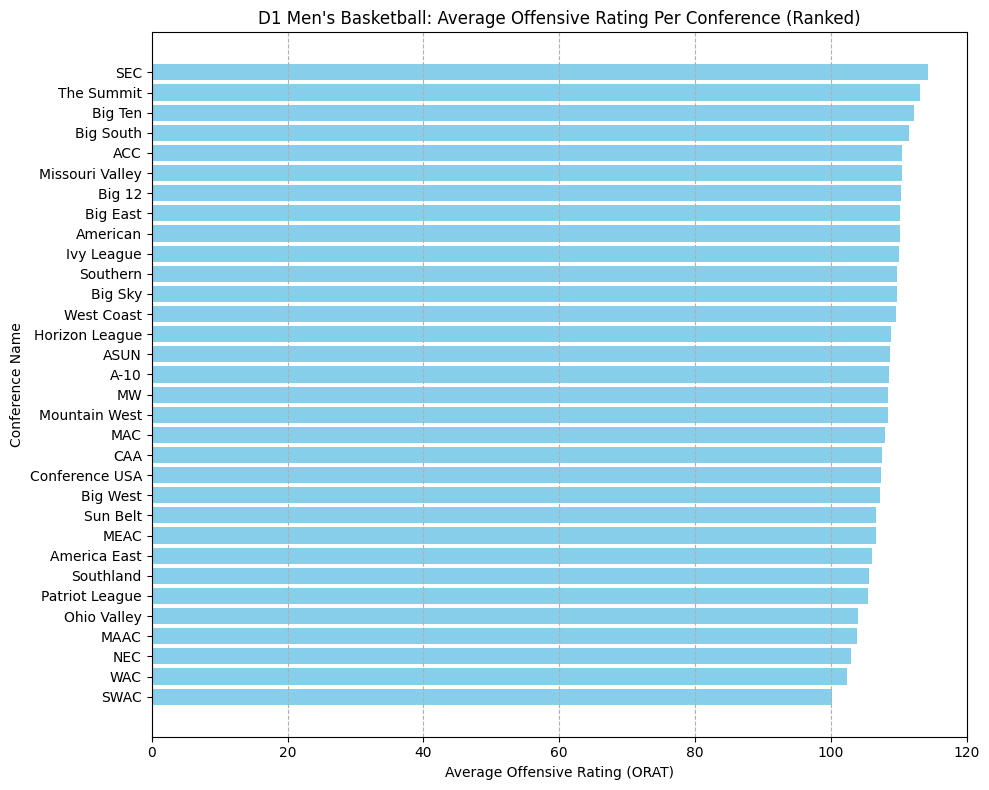

In [358]:
import pandas as pd
import matplotlib.pyplot as plt

# the plot dataframe is just the returned dataframe sorted by ORAT
plot = conference_averages.sort_values(by='Avg_Conference_ORAT', ascending=True)

# create a plot figure
plt.figure(figsize=(10, 8))

# Create a horizontal bar chart
plt.barh(plot['Conference_Name'], plot['Avg_Conference_ORAT'], color='skyblue')

# make the x and y labels, as well as the title
plt.xlabel('Average Offensive Rating (ORAT)')
plt.ylabel('Conference Name')
plt.title('D1 Men\'s Basketball: Average Offensive Rating Per Conference (Ranked)')
plt.grid(axis='x', linestyle='--')

plt.tight_layout()
plt.show()

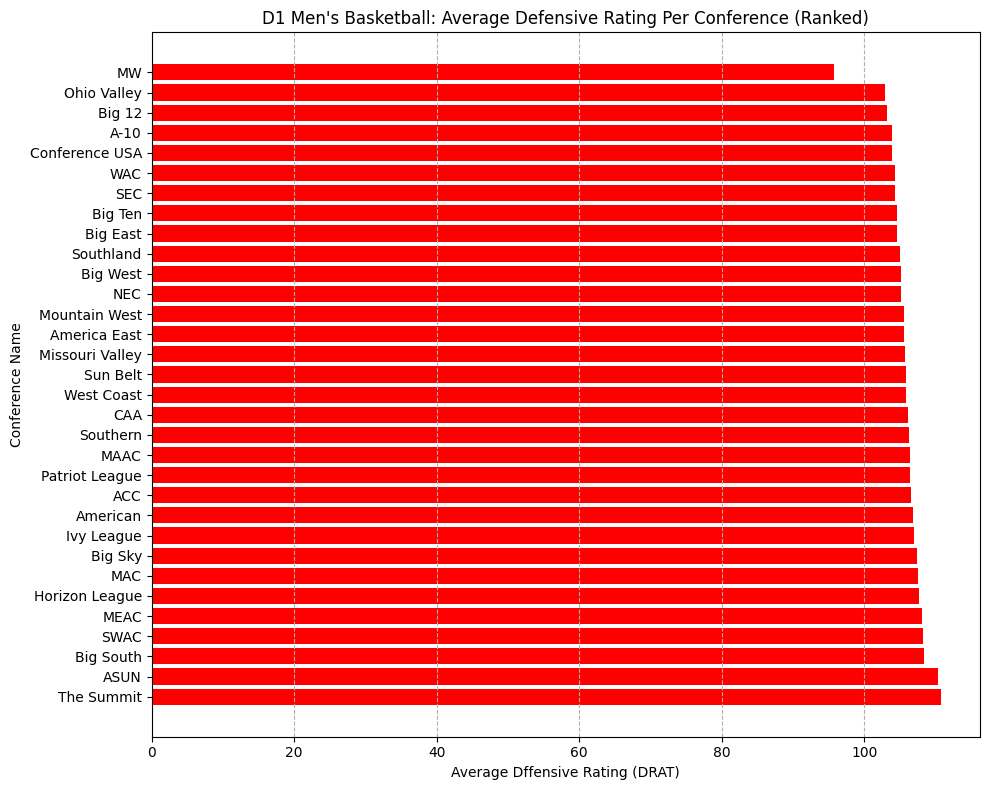

In [361]:
# basically the same thing but for the defenive rating

plot = conference_averages.sort_values(by='Avg_Conference_DRAT', ascending=False)

plt.figure(figsize=(10, 8))

# Create a horizontal bar chart
plt.barh(plot['Conference_Name'], plot['Avg_Conference_DRAT'], color='red')

plt.xlabel('Average Dffensive Rating (DRAT)')
plt.ylabel('Conference Name')
plt.title('D1 Men\'s Basketball: Average Defensive Rating Per Conference (Ranked)')
plt.grid(axis='x', linestyle='--')

plt.tight_layout()
plt.show()

In [1]:
# Lastly, same process but for the True Shooting %

plot = conference_averages.sort_values(by='Avg_Conference_TS_Pct', ascending=True)

plt.figure(figsize=(10, 8))

# Create a horizontal bar chart
plt.barh(plot['Conference_Name'], plot['Avg_Conference_TS_Pct'], color='green')

plt.xlabel('Average True Shooting Percentage (TS%)')
plt.ylabel('Conference Name')
plt.title('D1 Men\'s Basketball: Average True Shooting Percentage Per Conference (Ranked)')
plt.grid(axis='x', linestyle='--')

plt.tight_layout()
plt.show()

NameError: name 'conference_averages' is not defined